In [1]:
# !wget http://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz

# import tarfile
# with tarfile.open('notMNIST_small.tar.gz', 'r:gz') as tar:
#     tar.extractall()

# !ls notMNIST_small

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.image as mp
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [3]:
!nvidia-smi

Tue Oct  8 23:49:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:08:00.0 Off |                    0 |
| N/A   32C    P0             54W /  300W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
# GPU device
gpu_id = 3
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(f"Using device: {device}")

# Setting seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

Using device: cuda:3


In [5]:
def notMNIST_read(number_of_files, file):
    c = 10  # classes A-J (10)
    m = number_of_files

    trainX = np.zeros((m, 28 * 28), dtype=np.uint8)  # images are 28*28
    trainY = np.zeros((m, c), dtype=np.uint8)

    ix = 0
    for root, dirs, files in os.walk(file):
        for f in files:
            if f.endswith('.png'):
                try:
                    img = mp.imread(os.path.join(root, f))
                    if img.ndim == 3 and img.shape[2] == 4:
                        img = img[:, :, :3]  # Convert RGBA to RGB
                    trainX[ix, :] = img.reshape(-1)
                    folder = os.path.basename(root)  #os.path.split(root)[-1]
                    letter = ord(folder) - ord('A')  # A=0, B=1,..., J=9
                    trainY[ix, letter] = 1
                    print(f"Processing letter {folder}, file number {ix}\r", end='', flush=True)
                    ix += 1
                except Exception as e:
                    print(f"Error processing file {f}: {e}")
                    continue

    save_name = 'notMNIST_' + ('Large' if m == 529114 else 'small') + '_train'
    np.save(f'{save_name}X.npy', trainX[:ix])
    np.save(f'{save_name}Y.npy', trainY[:ix])

    return trainX, trainY

In [6]:
trainX,trainY = notMNIST_read(18724,r"/home/pthapa2/snap/padam/Project1/notMNIST_small")

Error processing file Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png: not a PNG file
Error processing file RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png: not a PNG file


In [7]:
# Load the notMNIST dataset
trainX = np.load('notMNIST_small_trainX.npy')
trainY = np.load('notMNIST_small_trainY.npy')

In [8]:
X = trainX/255
Y = trainY/1

In [9]:
X.dtype

dtype('float64')

In [10]:
X.shape, X.min(), X.max(), Y.shape, Y.min(), Y.max()

((18724, 784), 0.0, 0.00392156862745098, (18724, 10), 0.0, 1.0)

In [11]:
Y.sum(axis=0)

array([1872., 1873., 1873., 1873., 1873., 1872., 1872., 1872., 1872.,
       1872.])

In [12]:
# Standardize the input data
def standardize(X):
    X = X.astype(np.float64)
    Xm = np.mean(X, axis=1, keepdims=True)
    Xstd = np.std(X, axis=1, keepdims=True)
    Xstd[Xstd == 0] = 1  # Prevent division by zero
    X -= Xm
    X /= Xstd
    return X

trainX = standardize(trainX)

In [13]:
# Custom train-validation-test split function
def trainsplit(X, Y, percentV=0.2, percentT=0.2): #Try 0.15
    m = X.shape[0]
    ix = list(range(m))
    np.random.shuffle(ix)  # Randomize the DB index
    X = X[ix, :]
    Y = Y[ix, :]
    
    m_train = int(np.floor(m * (1 - percentV - percentT)))  # Cut off for training
    m_val = m_train + int(np.floor(m * percentV))            # Cut off for validation data
    
    X_train = X[:m_train, :]
    X_val = X[m_train:m_val, :]
    X_test = X[m_val:, :]
    
    Y_train = Y[:m_train]
    Y_val = Y[m_train:m_val]
    Y_test = Y[m_val:]
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [14]:
# Split the data into training, validation, and test sets
X_train, Y_train, X_val, Y_val, X_test, Y_test = trainsplit(trainX, trainY)


Note:

Larger batch sizes require more memory and may cause out-of-memory errors.

Larger batch sizes can be computationally efficient but may slow down beyond a point.

Smaller batch sizes: more noise, escape local minima, better generalization.

Larger batch sizes: stable gradients, sharper minima, may affect generalization.

Increase batch size ⇒ adjust learning rate accordingly.

Larger batch sizes often require higher learning rates.


In [15]:
# Convert standardized data to PyTorch tensors and move to device
trainX_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
trainY_tensor = torch.tensor(Y_train.argmax(axis=1), dtype=torch.long).to(device)
validX_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
validY_tensor = torch.tensor(Y_val.argmax(axis=1), dtype=torch.long).to(device)
testX_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
testY_tensor = torch.tensor(Y_test.argmax(axis=1), dtype=torch.long).to(device)

In [16]:
# Create DataLoaders for each dataset split
batch_size = 128
train_loader = DataLoader(TensorDataset(trainX_tensor, trainY_tensor), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(validX_tensor, validY_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(testX_tensor, testY_tensor), batch_size=batch_size)

In [17]:
# Print lengths of datasets
print(f"Training data length: {len(train_loader.dataset)}")
print(f"Validation data length: {len(valid_loader.dataset)}")
print(f"Test data length: {len(test_loader.dataset)}")

Training data length: 11234
Validation data length: 3744
Test data length: 3746


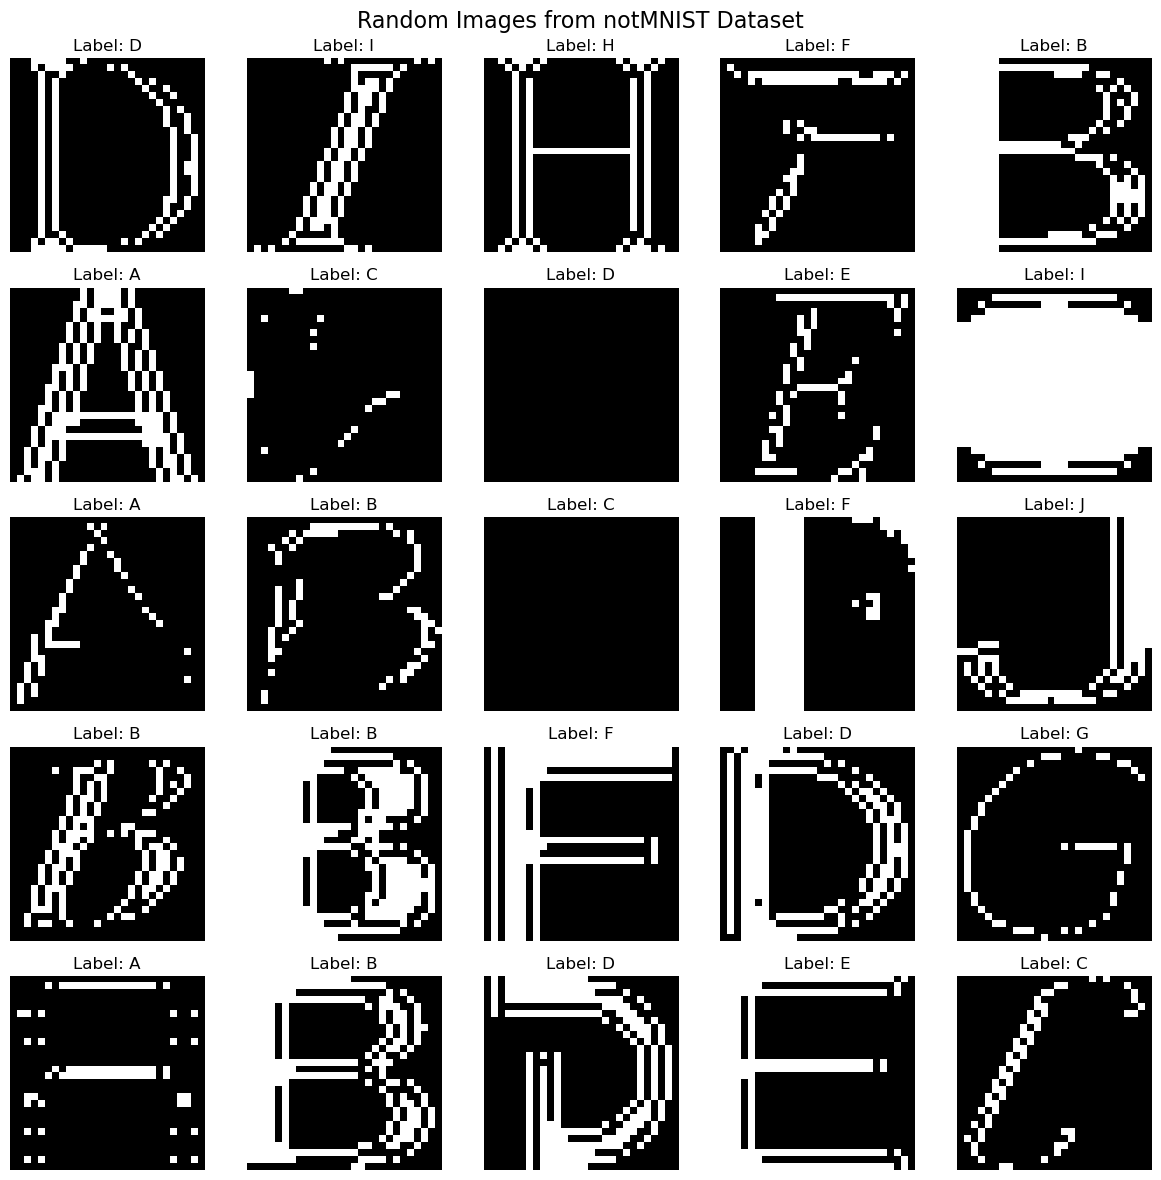

In [18]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
fig.suptitle("Random Images from notMNIST Dataset", fontsize=16)

# Iterate over axes and display random images
for ax in axes.flat:
    img, label = next(iter(train_loader))  # Get a random batch
    idx = np.random.randint(len(img))      # Random index within the batch
    ax.imshow(img[idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {chr(65 + label[idx].item())}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Report
### 1. Database: The database consists notMNIST image files, similar to MNIST but with letters A-J instead of digits.
### 2. Input Data: The input data consists of 28x28 grayscale images in PNG format.
### 3. Input Type: The input is a float64 data type. (dtype('float64'))
### 4. Input Dimensions: Images resized to (28, 28) pixels, flattened to 784-dimensional vectors.
### 5. Training Set: notMNIST_small, 11234 images in training set.
### 6. Test Set: 3744 for the validation set, 3746 for the test set. 

## Task 1: 4 Layered Network with 1 Input, 2 hidden layers, and 1 output layer.

In [19]:
# Define the neural network architecture
class Network121(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Network121, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [20]:
# Creating an instance of the model
input_size = 28 * 28
hidden_size1 = 512
hidden_size2 = 128
output_size = 10

model1 = Network121(input_size, hidden_size1, hidden_size2, output_size).to(device)
model1

Network121(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [21]:
print(f"Model is on device: {next(model1.parameters()).device}")
dummy_input = torch.randn(1, input_size).to(device)
summary(model1, input_size=(1, input_size), device=device.type)

Model is on device: cuda:3
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         401,920
            Linear-2               [-1, 1, 128]          65,664
            Linear-3                [-1, 1, 10]           1,290
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.79
Estimated Total Size (MB): 1.80
----------------------------------------------------------------


In [22]:
def accuracy(pred, label):
    pred_classes = pred.argmax(dim=1)
    # Comparing with true class indices directly
    return (pred_classes == label).type(torch.float).mean().item()

In [23]:
def train(dataloader, model, loss_fn, optimizer, metric, metric_name='batch accuracy'):
    num_batches = len(dataloader)
    total_loss = 0.0
    model.train()
    
    for batch, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        
        optimizer.zero_grad()
        Yhat = model(X)  # Forward pass through the model
        loss = loss_fn(Yhat, Y)
        loss.backward()  # Backpropagation - computing gradients
        optimizer.step()  # Updating model weights
        
        total_loss += loss.item()
        
        # Calc. and printing metrics after every batch
        avg_loss = total_loss / batch
        metric_value = metric(Yhat, Y)
        print(f"Batch: {batch:>5d}/{num_batches}, Avg_loss: {avg_loss:>7f}, {metric_name}: {metric_value:5f}", end='\r')
    
    print()  
    return total_loss

In [24]:
def test(dataloader, model, loss_fn, metric, metric_name = 'accuracy'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, metric_T = 0, 0
    with torch.no_grad():
        for X, Y in dataloader:
            Yhat = model(X)
            test_loss += loss_fn(Yhat, Y).item()
            metric_T += metric(Yhat, Y)* len(Y)
    test_loss /= num_batches
    metric_T /= size
    print(f"loss: {test_loss:>7f}, metric: { metric_T:>5f}")

In [25]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = optim.SGD(model1.parameters(), lr = 0.5)
loss_fn = nn.CrossEntropyLoss()

epochs = 20
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model1, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model1, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model1, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 2.301670, batch accuracy: 0.132653
Validation:
loss: 2.300538, metric: 0.091880

Epoch 2
Batch:    88/88, Avg_loss: 2.297984, batch accuracy: 0.316327
Validation:
loss: 2.295408, metric: 0.131677

Epoch 3
Batch:    88/88, Avg_loss: 2.286581, batch accuracy: 0.163265
Validation:
loss: 2.271729, metric: 0.179220

Epoch 4
Batch:    88/88, Avg_loss: 2.226163, batch accuracy: 0.265306
Validation:
loss: 2.183465, metric: 0.311432

Epoch 5
Batch:    88/88, Avg_loss: 2.117010, batch accuracy: 0.418367
Validation:
loss: 2.066136, metric: 0.416667

Epoch 6
Batch:    88/88, Avg_loss: 2.003533, batch accuracy: 0.438776
Validation:
loss: 1.971583, metric: 0.555288

Epoch 7
Batch:    88/88, Avg_loss: 1.926767, batch accuracy: 0.591837
Validation:
loss: 1.908268, metric: 0.580395

Epoch 8
Batch:    88/88, Avg_loss: 1.877638, batch accuracy: 0.622449
Validation:
loss: 1.871228, metric: 0.638889

Epoch 9
Batch:    88/88, Avg_loss: 1.844344, batch accuracy: 0.520408
V

## Task 2: 6 Layered Network with 1 Input, 4 hidden layers, and 1 output layer.

In [26]:
# Implementing Task 2 in a modular way as of Task 1
class Network141(nn.Module):
    def __init__(self, layer_sizes):
        super(Network141, self).__init__()
        self.L1 = nn.Linear(in_features=layer_sizes[0], out_features=layer_sizes[1]) # Input Layer to First Hidden Layer
        self.L2 = nn.Linear(in_features=layer_sizes[1], out_features=layer_sizes[2])
        self.L3 = nn.Linear(in_features=layer_sizes[2], out_features=layer_sizes[3])
        self.L4 = nn.Linear(in_features=layer_sizes[3], out_features=layer_sizes[4])
        self.out = nn.Linear(in_features=layer_sizes[4], out_features=layer_sizes[5]) # Fourth Hidden Layer to Output Layer

    def forward(self, x):
        x = x.to(self.L1.weight.dtype)       # Ensuring input tensor is of the same data type as model weights
        L1 = torch.sigmoid(self.L1(x))       # Pass through First Hidden Layer with Sigmoid Activation
        L2 = torch.sigmoid(self.L2(L1)) 
        L3 = torch.sigmoid(self.L3(L2))
        L4 = torch.sigmoid(self.L4(L3))
        out = F.softmax(self.out(L4), dim=1) # Pass through Output Layer with Softmax Activation for Probabilities

        return out

In [27]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10] #[28*28, 1024, 512, 256, 100, 10]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = Network141(layer_sizes).to(device)

optimizer = optim.SGD(model2.parameters(), lr = 0.5) # Tried with 0.1, 0.01, 0.001 - gave the same test results. 
loss_fn = nn.CrossEntropyLoss()

epochs = 50
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model2, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model2, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model2, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 2.303007, batch accuracy: 0.040816
Validation:
loss: 2.303067, metric: 0.097222

Epoch 2
Batch:    88/88, Avg_loss: 2.302749, batch accuracy: 0.142857
Validation:
loss: 2.303158, metric: 0.096154

Epoch 3
Batch:    88/88, Avg_loss: 2.302742, batch accuracy: 0.061224
Validation:
loss: 2.303150, metric: 0.091880

Epoch 4
Batch:    88/88, Avg_loss: 2.302772, batch accuracy: 0.071429
Validation:
loss: 2.303457, metric: 0.097222

Epoch 5
Batch:    88/88, Avg_loss: 2.302784, batch accuracy: 0.112245
Validation:
loss: 2.303361, metric: 0.097222

Epoch 6
Batch:    88/88, Avg_loss: 2.302688, batch accuracy: 0.102041
Validation:
loss: 2.303166, metric: 0.097222

Epoch 7
Batch:    88/88, Avg_loss: 2.302669, batch accuracy: 0.102041
Validation:
loss: 2.303150, metric: 0.091880

Epoch 8
Batch:    88/88, Avg_loss: 2.302701, batch accuracy: 0.112245
Validation:
loss: 2.303258, metric: 0.097222

Epoch 9
Batch:    88/88, Avg_loss: 2.302762, batch accuracy: 0.081633
V

Here the model is Overparameterized resulting in no learning or zero accuracy! Let's experiment with the ReLU for the hidden layer

## Task 3: Experimentation with ReLU for the Hidden Layer

In [28]:
class Network_relu(nn.Module):
    def __init__(self, layer_sizes):
        super(Network_relu, self).__init__()
        self.L1 = nn.Linear(in_features=layer_sizes[0], out_features=layer_sizes[1])
        self.L2 = nn.Linear(in_features=layer_sizes[1], out_features=layer_sizes[2])
        self.L3 = nn.Linear(in_features=layer_sizes[2], out_features=layer_sizes[3])
        self.L4 = nn.Linear(in_features=layer_sizes[3], out_features=layer_sizes[4])
        self.out = nn.Linear(in_features=layer_sizes[4], out_features=layer_sizes[5])

    def forward(self, x):
        x = x.to(self.L1.weight.dtype)
        L1 = F.relu(self.L1(x))
        L2 = F.relu(self.L2(L1))
        L3 = F.relu(self.L3(L2))
        L4 = F.relu(self.L4(L3))
        out = F.softmax(self.out(L4), dim=1)
        
        return out

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = Network_relu(layer_sizes).to(device)

In [29]:
summary(model3, input_size=(1, input_size), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1000]         785,000
            Linear-2               [-1, 1, 500]         500,500
            Linear-3               [-1, 1, 250]         125,250
            Linear-4               [-1, 1, 100]          25,100
            Linear-5                [-1, 1, 10]           1,010
Total params: 1,436,860
Trainable params: 1,436,860
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 5.48
Estimated Total Size (MB): 5.50
----------------------------------------------------------------


In [30]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = optim.SGD(model3.parameters(), lr = 0.5)
loss_fn = nn.CrossEntropyLoss()

epochs = 20
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model3, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model3, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model3, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 2.300461, batch accuracy: 0.214286
Validation:
loss: 2.296251, metric: 0.240919

Epoch 2
Batch:    88/88, Avg_loss: 2.158938, batch accuracy: 0.387755
Validation:
loss: 1.937823, metric: 0.485310

Epoch 3
Batch:    88/88, Avg_loss: 1.767216, batch accuracy: 0.846939
Validation:
loss: 1.702908, metric: 0.773771

Epoch 4
Batch:    88/88, Avg_loss: 1.653919, batch accuracy: 0.826531
Validation:
loss: 1.655903, metric: 0.818109

Epoch 5
Batch:    88/88, Avg_loss: 1.609705, batch accuracy: 0.846939
Validation:
loss: 1.642217, metric: 0.825588

Epoch 6
Batch:    88/88, Avg_loss: 1.589937, batch accuracy: 0.877551
Validation:
loss: 1.630708, metric: 0.833066

Epoch 7
Batch:    88/88, Avg_loss: 1.576553, batch accuracy: 0.867347
Validation:
loss: 1.630301, metric: 0.833333

Epoch 8
Batch:    88/88, Avg_loss: 1.564456, batch accuracy: 0.867347
Validation:
loss: 1.634018, metric: 0.830128

Epoch 9
Batch:    88/88, Avg_loss: 1.560149, batch accuracy: 0.908163
V

So far, the ReLU activation function in the hidden layers has proven to be the most effective, as it provides higher accuracy compared to other activation functions. 

## Task 4.1: Experimentation with Nestrov

In [31]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4 = Network_relu(layer_sizes).to(device)
momentum = 0.9
optimizer = optim.SGD(model4.parameters(), lr = 0.01, momentum=momentum, nesterov=True)
loss_fn = nn.CrossEntropyLoss()

epochs = 20
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model4, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model4, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model4, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 2.302473, batch accuracy: 0.091837
Validation:
loss: 2.302063, metric: 0.129808

Epoch 2
Batch:    88/88, Avg_loss: 2.301885, batch accuracy: 0.234694
Validation:
loss: 2.301404, metric: 0.173611

Epoch 3
Batch:    88/88, Avg_loss: 2.301090, batch accuracy: 0.265306
Validation:
loss: 2.300469, metric: 0.240652

Epoch 4
Batch:    88/88, Avg_loss: 2.299903, batch accuracy: 0.346939
Validation:
loss: 2.298998, metric: 0.297009

Epoch 5
Batch:    88/88, Avg_loss: 2.297915, batch accuracy: 0.336735
Validation:
loss: 2.296377, metric: 0.342949

Epoch 6
Batch:    88/88, Avg_loss: 2.294043, batch accuracy: 0.408163
Validation:
loss: 2.290862, metric: 0.458600

Epoch 7
Batch:    88/88, Avg_loss: 2.284280, batch accuracy: 0.489796
Validation:
loss: 2.274701, metric: 0.366720

Epoch 8
Batch:    88/88, Avg_loss: 2.244543, batch accuracy: 0.255102
Validation:
loss: 2.209526, metric: 0.225160

Epoch 9
Batch:    88/88, Avg_loss: 2.149002, batch accuracy: 0.489796
V

Comment on the performance: When I raise the learning rate from 0.001 to 0.01, the test accuracy improves from 0.35 to 0.845168 with the epoch 20. Nonetheless, with a learning rate of 0.001, we can still achieve higher accuracy by training the model for additional epochs and when done for 200 epochs, it achieved the same test accuracy as 0.84383 as shown below! 


In [32]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4 = Network_relu(layer_sizes).to(device)
momentum = 0.9
optimizer = optim.SGD(model4.parameters(), lr = 0.001, momentum=momentum, nesterov=True)
loss_fn = nn.CrossEntropyLoss()

epochs = 200
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model4, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model4, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model4, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 2.302663, batch accuracy: 0.091837
Validation:
loss: 2.302496, metric: 0.103632

Epoch 2
Batch:    88/88, Avg_loss: 2.302610, batch accuracy: 0.173469
Validation:
loss: 2.302445, metric: 0.106571

Epoch 3
Batch:    88/88, Avg_loss: 2.302557, batch accuracy: 0.153061
Validation:
loss: 2.302394, metric: 0.111378

Epoch 4
Batch:    88/88, Avg_loss: 2.302503, batch accuracy: 0.132653
Validation:
loss: 2.302342, metric: 0.115652

Epoch 5
Batch:    88/88, Avg_loss: 2.302454, batch accuracy: 0.112245
Validation:
loss: 2.302289, metric: 0.119124

Epoch 6
Batch:    88/88, Avg_loss: 2.302398, batch accuracy: 0.102041
Validation:
loss: 2.302236, metric: 0.121795

Epoch 7
Batch:    88/88, Avg_loss: 2.302340, batch accuracy: 0.173469
Validation:
loss: 2.302181, metric: 0.124733

Epoch 8
Batch:    88/88, Avg_loss: 2.302285, batch accuracy: 0.153061
Validation:
loss: 2.302125, metric: 0.128205

Epoch 9
Batch:    88/88, Avg_loss: 2.302228, batch accuracy: 0.112245
V

## Task 4.2: Experimentation with Adam

In [33]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
model5 = Network_relu(layer_sizes).to(device)
optimizer = optim.Adam(model5.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

epochs = 50
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model5, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model5, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model5, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 2.107163, batch accuracy: 0.653061
Validation:
loss: 1.804107, metric: 0.691506

Epoch 2
Batch:    88/88, Avg_loss: 1.690895, batch accuracy: 0.795918
Validation:
loss: 1.657764, metric: 0.812500

Epoch 3
Batch:    88/88, Avg_loss: 1.631485, batch accuracy: 0.836735
Validation:
loss: 1.643273, metric: 0.821047

Epoch 4
Batch:    88/88, Avg_loss: 1.610457, batch accuracy: 0.887755
Validation:
loss: 1.640285, metric: 0.841880

Epoch 5
Batch:    88/88, Avg_loss: 1.595164, batch accuracy: 0.867347
Validation:
loss: 1.635594, metric: 0.844818

Epoch 6
Batch:    88/88, Avg_loss: 1.583540, batch accuracy: 0.887755
Validation:
loss: 1.628597, metric: 0.848558

Epoch 7
Batch:    88/88, Avg_loss: 1.573976, batch accuracy: 0.908163
Validation:
loss: 1.624469, metric: 0.854701

Epoch 8
Batch:    88/88, Avg_loss: 1.566346, batch accuracy: 0.928571
Validation:
loss: 1.624127, metric: 0.854968

Epoch 9
Batch:    88/88, Avg_loss: 1.560112, batch accuracy: 0.887755
V

So far, the highest accuracy has been achieved using the ADAM optimizer with a learning rate of 0.001, resulting in a test accuracy of 0.864.


## Task 5: Implementing Dropout

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network_dropout(nn.Module):
    def __init__(self, layer_sizes, dropout_prob=0.5):
        super(Network_dropout, self).__init__()
        self.L1 = nn.Linear(in_features=layer_sizes[0], out_features=layer_sizes[1])
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.L2 = nn.Linear(in_features=layer_sizes[1], out_features=layer_sizes[2])
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.L3 = nn.Linear(in_features=layer_sizes[2], out_features=layer_sizes[3])
        self.dropout3 = nn.Dropout(p=dropout_prob)
        self.L4 = nn.Linear(in_features=layer_sizes[3], out_features=layer_sizes[4])
        self.dropout4 = nn.Dropout(p=dropout_prob)
        self.out = nn.Linear(in_features=layer_sizes[4], out_features=layer_sizes[5])

    def forward(self, x):
        x = x.to(self.L1.weight.dtype)
        L1 = F.relu(self.L1(x))
        L1 = self.dropout1(L1)
        L2 = F.relu(self.L2(L1))
        L2 = self.dropout2(L2)
        L3 = F.relu(self.L3(L2))
        L3 = self.dropout3(L3)
        L4 = F.relu(self.L4(L3))
        L4 = self.dropout4(L4)
        out = F.softmax(self.out(L4), dim=1)
        
        return out

In [35]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
model6 = Network_dropout(layer_sizes).to(device)
optimizer = optim.Adam(model6.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

summary(model6, input_size=(1, input_size), device=device.type)

epochs = 50
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model6, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model6, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model6, loss_fn, accuracy)
print("Done!")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1000]         785,000
           Dropout-2              [-1, 1, 1000]               0
            Linear-3               [-1, 1, 500]         500,500
           Dropout-4               [-1, 1, 500]               0
            Linear-5               [-1, 1, 250]         125,250
           Dropout-6               [-1, 1, 250]               0
            Linear-7               [-1, 1, 100]          25,100
           Dropout-8               [-1, 1, 100]               0
            Linear-9                [-1, 1, 10]           1,010
Total params: 1,436,860
Trainable params: 1,436,860
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 5.48
Estimated Total Size (MB): 5.51
---------------------------------------

The performance of dropout barely improved in this case. Perhaps using a different batch size for the dataset could enhance the accuracy.

## Task 6: Implementing Batch Normalization

In [36]:
class Network_batchnorm(nn.Module):
    def __init__(self, layer_sizes):
        super(Network_batchnorm, self).__init__()
        self.L1 = nn.Linear(in_features=layer_sizes[0], out_features=layer_sizes[1])
        self.bn1 = nn.BatchNorm1d(layer_sizes[1])
        self.L2 = nn.Linear(in_features=layer_sizes[1], out_features=layer_sizes[2])
        self.bn2 = nn.BatchNorm1d(layer_sizes[2])
        self.L3 = nn.Linear(in_features=layer_sizes[2], out_features=layer_sizes[3])
        self.bn3 = nn.BatchNorm1d(layer_sizes[3])
        self.L4 = nn.Linear(in_features=layer_sizes[3], out_features=layer_sizes[4])
        self.bn4 = nn.BatchNorm1d(layer_sizes[4])
        self.out = nn.Linear(in_features=layer_sizes[4], out_features=layer_sizes[5])

    def forward(self, x):
        x = x.to(self.L1.weight.dtype)
        L1 = F.relu(self.bn1(self.L1(x)))
        L2 = F.relu(self.bn2(self.L2(L1)))
        L3 = F.relu(self.bn3(self.L3(L2)))
        L4 = F.relu(self.bn4(self.L4(L3)))
        out = F.softmax(self.out(L4), dim=1)
        
        return out

In [37]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
model7 = Network_batchnorm(layer_sizes).to(device)
optimizer = optim.Adam(model7.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

epochs = 50
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model7, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model7, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model7, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 2.019475, batch accuracy: 0.724490
Validation:
loss: 1.853032, metric: 0.811165

Epoch 2
Batch:    88/88, Avg_loss: 1.779722, batch accuracy: 0.826531
Validation:
loss: 1.746288, metric: 0.842415

Epoch 3
Batch:    88/88, Avg_loss: 1.693249, batch accuracy: 0.908163
Validation:
loss: 1.697710, metric: 0.850694

Epoch 4
Batch:    88/88, Avg_loss: 1.642014, batch accuracy: 0.877551
Validation:
loss: 1.670465, metric: 0.856571

Epoch 5
Batch:    88/88, Avg_loss: 1.603418, batch accuracy: 0.897959
Validation:
loss: 1.656244, metric: 0.859509

Epoch 6
Batch:    88/88, Avg_loss: 1.573324, batch accuracy: 0.908163
Validation:
loss: 1.645980, metric: 0.859509

Epoch 7
Batch:    88/88, Avg_loss: 1.551928, batch accuracy: 0.979592
Validation:
loss: 1.641536, metric: 0.858974

Epoch 8
Batch:    88/88, Avg_loss: 1.536795, batch accuracy: 0.969388
Validation:
loss: 1.636454, metric: 0.859509

Epoch 9
Batch:    88/88, Avg_loss: 1.524945, batch accuracy: 0.928571
V

The best accuracy that we got up until now is from batch normalization that is 0.873

## Task 7: Relu Variants

1. Leaky ReLU

In [38]:
class Network_leakyrelu(nn.Module):
    def __init__(self, layer_sizes):
        super(Network_leakyrelu, self).__init__()
        self.L1 = nn.Linear(in_features=layer_sizes[0], out_features=layer_sizes[1])
        self.bn1 = nn.BatchNorm1d(layer_sizes[1])
        self.L2 = nn.Linear(in_features=layer_sizes[1], out_features=layer_sizes[2])
        self.bn2 = nn.BatchNorm1d(layer_sizes[2])
        self.L3 = nn.Linear(in_features=layer_sizes[2], out_features=layer_sizes[3])
        self.bn3 = nn.BatchNorm1d(layer_sizes[3])
        self.L4 = nn.Linear(in_features=layer_sizes[3], out_features=layer_sizes[4])
        self.bn4 = nn.BatchNorm1d(layer_sizes[4])
        self.out = nn.Linear(in_features=layer_sizes[4], out_features=layer_sizes[5])

    def forward(self, x):
        x = x.to(self.L1.weight.dtype)
        L1 = F.leaky_relu(self.bn1(self.L1(x)))
        L2 = F.leaky_relu(self.bn2(self.L2(L1)))
        L3 = F.leaky_relu(self.bn3(self.L3(L2)))
        L4 = F.leaky_relu(self.bn4(self.L4(L3)))
        out = F.softmax(self.out(L4), dim=1)
        
        return out

In [39]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
model8 = Network_leakyrelu(layer_sizes).to(device)
optimizer = optim.Adam(model8.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

epochs = 100
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model8, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model8, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model8, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 2.015140, batch accuracy: 0.724490
Validation:
loss: 1.849782, metric: 0.810897

Epoch 2
Batch:    88/88, Avg_loss: 1.777767, batch accuracy: 0.826531
Validation:
loss: 1.745121, metric: 0.842415

Epoch 3
Batch:    88/88, Avg_loss: 1.692331, batch accuracy: 0.908163
Validation:
loss: 1.697112, metric: 0.849893

Epoch 4
Batch:    88/88, Avg_loss: 1.641513, batch accuracy: 0.887755
Validation:
loss: 1.670214, metric: 0.855769

Epoch 5
Batch:    88/88, Avg_loss: 1.603238, batch accuracy: 0.897959
Validation:
loss: 1.656239, metric: 0.859241

Epoch 6
Batch:    88/88, Avg_loss: 1.573153, batch accuracy: 0.897959
Validation:
loss: 1.645919, metric: 0.860043

Epoch 7
Batch:    88/88, Avg_loss: 1.551768, batch accuracy: 0.979592
Validation:
loss: 1.641550, metric: 0.858173

Epoch 8
Batch:    88/88, Avg_loss: 1.536759, batch accuracy: 0.969388
Validation:
loss: 1.636735, metric: 0.861378

Epoch 9
Batch:    88/88, Avg_loss: 1.524746, batch accuracy: 0.928571
V

2. Exponential ReLU

In [40]:
class Network_exprelu(nn.Module):
    def __init__(self, layer_sizes):
        super(Network_exprelu, self).__init__()
        self.L1 = nn.Linear(in_features=layer_sizes[0], out_features=layer_sizes[1])
        self.bn1 = nn.BatchNorm1d(layer_sizes[1])
        self.L2 = nn.Linear(in_features=layer_sizes[1], out_features=layer_sizes[2])
        self.bn2 = nn.BatchNorm1d(layer_sizes[2])
        self.L3 = nn.Linear(in_features=layer_sizes[2], out_features=layer_sizes[3])
        self.bn3 = nn.BatchNorm1d(layer_sizes[3])
        self.L4 = nn.Linear(in_features=layer_sizes[3], out_features=layer_sizes[4])
        self.bn4 = nn.BatchNorm1d(layer_sizes[4])
        self.out = nn.Linear(in_features=layer_sizes[4], out_features=layer_sizes[5])

    def forward(self, x):
        x = x.to(self.L1.weight.dtype)
        L1 = F.elu(self.bn1(self.L1(x)))
        L2 = F.elu(self.bn2(self.L2(L1)))
        L3 = F.elu(self.bn3(self.L3(L2)))
        L4 = F.elu(self.bn4(self.L4(L3)))
        out = F.softmax(self.out(L4), dim=1)
        
        return out

In [42]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
model9 = Network_exprelu(layer_sizes).to(device)
optimizer = optim.Adam(model9.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

epochs = 100
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model9, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model9, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model9, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 1.873280, batch accuracy: 0.775510
Validation:
loss: 1.752287, metric: 0.826923

Epoch 2
Batch:    88/88, Avg_loss: 1.707236, batch accuracy: 0.857143
Validation:
loss: 1.697811, metric: 0.841613

Epoch 3
Batch:    88/88, Avg_loss: 1.659504, batch accuracy: 0.877551
Validation:
loss: 1.672827, metric: 0.845620

Epoch 4
Batch:    88/88, Avg_loss: 1.630255, batch accuracy: 0.867347
Validation:
loss: 1.659294, metric: 0.851496

Epoch 5
Batch:    88/88, Avg_loss: 1.607150, batch accuracy: 0.897959
Validation:
loss: 1.651565, metric: 0.852564

Epoch 6
Batch:    88/88, Avg_loss: 1.586095, batch accuracy: 0.867347
Validation:
loss: 1.641762, metric: 0.853098

Epoch 7
Batch:    88/88, Avg_loss: 1.571453, batch accuracy: 0.948980
Validation:
loss: 1.640150, metric: 0.850160

Epoch 8
Batch:    88/88, Avg_loss: 1.560029, batch accuracy: 0.959184
Validation:
loss: 1.635564, metric: 0.854167

Epoch 9
Batch:    88/88, Avg_loss: 1.549511, batch accuracy: 0.897959
V

3. Parametric ReLU:

In [43]:
class Network_prelu(nn.Module):
    def __init__(self, layer_sizes):
        super(Network_prelu, self).__init__()
        self.L1 = nn.Linear(in_features=layer_sizes[0], out_features=layer_sizes[1])
        self.bn1 = nn.BatchNorm1d(layer_sizes[1])
        self.prelu1 = nn.PReLU()
        
        self.L2 = nn.Linear(in_features=layer_sizes[1], out_features=layer_sizes[2])
        self.bn2 = nn.BatchNorm1d(layer_sizes[2])
        self.prelu2 = nn.PReLU()
        
        self.L3 = nn.Linear(in_features=layer_sizes[2], out_features=layer_sizes[3])
        self.bn3 = nn.BatchNorm1d(layer_sizes[3])
        self.prelu3 = nn.PReLU()
        
        self.L4 = nn.Linear(in_features=layer_sizes[3], out_features=layer_sizes[4])
        self.bn4 = nn.BatchNorm1d(layer_sizes[4])
        self.prelu4 = nn.PReLU()
        
        self.out = nn.Linear(in_features=layer_sizes[4], out_features=layer_sizes[5])

    def forward(self, x):
        x = x.to(self.L1.weight.dtype)
        L1 = self.prelu1(self.bn1(self.L1(x)))
        L2 = self.prelu2(self.bn2(self.L2(L1)))
        L3 = self.prelu3(self.bn3(self.L3(L2)))
        L4 = self.prelu4(self.bn4(self.L4(L3)))
        out = F.softmax(self.out(L4), dim=1)
        
        return out

In [44]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
model10 = Network_prelu(layer_sizes).to(device)
optimizer = optim.Adam(model10.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

epochs = 50
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model10, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model10, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model10, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 1.935730, batch accuracy: 0.744898
Validation:
loss: 1.797427, metric: 0.821314

Epoch 2
Batch:    88/88, Avg_loss: 1.742964, batch accuracy: 0.836735
Validation:
loss: 1.721932, metric: 0.841079

Epoch 3
Batch:    88/88, Avg_loss: 1.676881, batch accuracy: 0.887755
Validation:
loss: 1.685942, metric: 0.848291

Epoch 4
Batch:    88/88, Avg_loss: 1.635752, batch accuracy: 0.877551
Validation:
loss: 1.664925, metric: 0.855769

Epoch 5
Batch:    88/88, Avg_loss: 1.602872, batch accuracy: 0.908163
Validation:
loss: 1.653069, metric: 0.857372

Epoch 6
Batch:    88/88, Avg_loss: 1.575062, batch accuracy: 0.887755
Validation:
loss: 1.643063, metric: 0.858974

Epoch 7
Batch:    88/88, Avg_loss: 1.555488, batch accuracy: 0.979592
Validation:
loss: 1.640505, metric: 0.855235

Epoch 8
Batch:    88/88, Avg_loss: 1.541574, batch accuracy: 0.969388
Validation:
loss: 1.636148, metric: 0.857105

Epoch 9
Batch:    88/88, Avg_loss: 1.529749, batch accuracy: 0.918367
V

4. Exponential Linear Unit (ELU)

In [45]:
import torch.nn as nn
import torch.nn.functional as F

class Network_exprelu(nn.Module):
    def __init__(self, layer_sizes):
        super(Network_exprelu, self).__init__()
        self.L1 = nn.Linear(in_features=layer_sizes[0], out_features=layer_sizes[1])
        self.bn1 = nn.BatchNorm1d(layer_sizes[1])
        self.L2 = nn.Linear(in_features=layer_sizes[1], out_features=layer_sizes[2])
        self.bn2 = nn.BatchNorm1d(layer_sizes[2])
        self.L3 = nn.Linear(in_features=layer_sizes[2], out_features=layer_sizes[3])
        self.bn3 = nn.BatchNorm1d(layer_sizes[3])
        self.L4 = nn.Linear(in_features=layer_sizes[3], out_features=layer_sizes[4])
        self.bn4 = nn.BatchNorm1d(layer_sizes[4])
        self.out = nn.Linear(in_features=layer_sizes[4], out_features=layer_sizes[5])

    def forward(self, x):
        x = x.to(self.L1.weight.dtype)
        
        L1 = F.elu(self.bn1(self.L1(x)))
        L2 = F.elu(self.bn2(self.L2(L1)))
        L3 = F.elu(self.bn3(self.L3(L2)))
        L4 = F.elu(self.bn4(self.L4(L3)))
        
        out = F.softmax(self.out(L4), dim=1)
        
        return out

In [46]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
model11 = Network_exprelu(layer_sizes).to(device)
optimizer = optim.Adam(model11.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

epochs = 100
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model11, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model11, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model11, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 1.873280, batch accuracy: 0.775510
Validation:
loss: 1.752287, metric: 0.826923

Epoch 2
Batch:    88/88, Avg_loss: 1.707236, batch accuracy: 0.857143
Validation:
loss: 1.697811, metric: 0.841613

Epoch 3
Batch:    88/88, Avg_loss: 1.659504, batch accuracy: 0.877551
Validation:
loss: 1.672827, metric: 0.845620

Epoch 4
Batch:    88/88, Avg_loss: 1.630255, batch accuracy: 0.867347
Validation:
loss: 1.659294, metric: 0.851496

Epoch 5
Batch:    88/88, Avg_loss: 1.607150, batch accuracy: 0.897959
Validation:
loss: 1.651565, metric: 0.852564

Epoch 6
Batch:    88/88, Avg_loss: 1.586095, batch accuracy: 0.867347
Validation:
loss: 1.641762, metric: 0.853098

Epoch 7
Batch:    88/88, Avg_loss: 1.571453, batch accuracy: 0.948980
Validation:
loss: 1.640150, metric: 0.850160

Epoch 8
Batch:    88/88, Avg_loss: 1.560029, batch accuracy: 0.959184
Validation:
loss: 1.635564, metric: 0.854167

Epoch 9
Batch:    88/88, Avg_loss: 1.549511, batch accuracy: 0.897959
V

5. Scaled Exponential Linear Unit (SELU)

In [47]:
import torch.nn as nn
import torch.nn.functional as F

class Network_scaledrelu(nn.Module):
    def __init__(self, layer_sizes):
        super(Network_scaledrelu, self).__init__()
        self.L1 = nn.Linear(in_features=layer_sizes[0], out_features=layer_sizes[1])
        self.bn1 = nn.BatchNorm1d(layer_sizes[1])
        self.L2 = nn.Linear(in_features=layer_sizes[1], out_features=layer_sizes[2])
        self.bn2 = nn.BatchNorm1d(layer_sizes[2])
        self.L3 = nn.Linear(in_features=layer_sizes[2], out_features=layer_sizes[3])
        self.bn3 = nn.BatchNorm1d(layer_sizes[3])
        self.L4 = nn.Linear(in_features=layer_sizes[3], out_features=layer_sizes[4])
        self.bn4 = nn.BatchNorm1d(layer_sizes[4])
        self.out = nn.Linear(in_features=layer_sizes[4], out_features=layer_sizes[5])

    def forward(self, x):
        x = x.to(self.L1.weight.dtype)
        
        L1 = F.selu(self.bn1(self.L1(x)))
        L2 = F.selu(self.bn2(self.L2(L1)))
        L3 = F.selu(self.bn3(self.L3(L2)))
        L4 = F.selu(self.bn4(self.L4(L3)))
        
        out = F.softmax(self.out(L4), dim=1)
        
        return out

In [48]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

layer_sizes = [28*28, 1000, 500, 250, 100, 10]
model12 = Network_scaledrelu(layer_sizes).to(device)
optimizer = optim.Adam(model12.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

epochs = 50
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model12, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model12, loss_fn, accuracy)
print('\nTesting:')
test (test_loader, model12, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 1.827345, batch accuracy: 0.765306
Validation:
loss: 1.725183, metric: 0.818109

Epoch 2
Batch:    88/88, Avg_loss: 1.686120, batch accuracy: 0.826531
Validation:
loss: 1.686366, metric: 0.836806

Epoch 3
Batch:    88/88, Avg_loss: 1.648674, batch accuracy: 0.857143
Validation:
loss: 1.668546, metric: 0.842682

Epoch 4
Batch:    88/88, Avg_loss: 1.624816, batch accuracy: 0.877551
Validation:
loss: 1.658751, metric: 0.844551

Epoch 5
Batch:    88/88, Avg_loss: 1.606234, batch accuracy: 0.897959
Validation:
loss: 1.652660, metric: 0.847222

Epoch 6
Batch:    88/88, Avg_loss: 1.589059, batch accuracy: 0.846939
Validation:
loss: 1.644465, metric: 0.849626

Epoch 7
Batch:    88/88, Avg_loss: 1.576350, batch accuracy: 0.928571
Validation:
loss: 1.642992, metric: 0.843216

Epoch 8
Batch:    88/88, Avg_loss: 1.565608, batch accuracy: 0.938775
Validation:
loss: 1.638643, metric: 0.845887

Epoch 9
Batch:    88/88, Avg_loss: 1.557402, batch accuracy: 0.897959
V

Out of all, the LeakyRelu gave us the mildly best performance but almost similar results as of all variants of ReLU! 

## Task 8: Find the best L2 parameter (Weight Decay)

In [49]:
def test(dataloader, model, loss_fn, metric, metric_name = 'accuracy'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, metric_T = 0, 0
    with torch.no_grad():
        for X, Y in dataloader:
            Yhat = model(X)
            test_loss += loss_fn(Yhat, Y).item()
            metric_T += metric(Yhat, Y)* len(Y)
    test_loss /= num_batches
    metric_T /= size
    print(f"loss: {test_loss:>7f}, metric: { metric_T:>5f}")
    return metric_T

In [54]:
layer_sizes = [28*28, 1000, 500, 250, 100, 10]

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

weight_decay_values = [0.0001, 0.001, 0.01, 0.1, 1]
best_weight_decay = 0
best_accuracy = 0

for weight_decay in weight_decay_values:
    model13 = Network_leakyrelu(layer_sizes).to(device)

    optimizer = optim.Adam(model13.parameters(), lr=0.0005, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    print(f"For weight_decay: {weight_decay}")
    epochs = 30
    for t in range(epochs):
        print(f"\nEpoch {t+1}")
        train(train_loader, model13, loss_fn, optimizer, accuracy)
        print('Validation:')
        test(valid_loader, model13, loss_fn, accuracy)
    print('\nTesting:')
    test_accuracy = test(test_loader, model13, loss_fn, accuracy)
    print("Done!")
    
    if test_accuracy > best_accuracy:
        best_weight_decay = weight_decay
        best_accuracy = test_accuracy
        
print(f"Best Weight Decay value: {best_weight_decay}")

For weight_decay: 0.0001

Epoch 1
Batch:    88/88, Avg_loss: 1.805735, batch accuracy: 0.734694
Validation:
loss: 1.667326, metric: 0.845353

Epoch 2
Batch:    88/88, Avg_loss: 1.614441, batch accuracy: 0.836735
Validation:
loss: 1.629451, metric: 0.856036

Epoch 3
Batch:    88/88, Avg_loss: 1.573640, batch accuracy: 0.908163
Validation:
loss: 1.623562, metric: 0.853632

Epoch 4
Batch:    88/88, Avg_loss: 1.553700, batch accuracy: 0.928571
Validation:
loss: 1.614538, metric: 0.857372

Epoch 5
Batch:    88/88, Avg_loss: 1.540345, batch accuracy: 0.928571
Validation:
loss: 1.617125, metric: 0.851229

Epoch 6
Batch:    88/88, Avg_loss: 1.531648, batch accuracy: 0.897959
Validation:
loss: 1.609618, metric: 0.857372

Epoch 7
Batch:    88/88, Avg_loss: 1.526692, batch accuracy: 0.959184
Validation:
loss: 1.613296, metric: 0.853632

Epoch 8
Batch:    88/88, Avg_loss: 1.524158, batch accuracy: 0.979592
Validation:
loss: 1.616939, metric: 0.846688

Epoch 9
Batch:    88/88, Avg_loss: 1.522236, b

From this experiment, I found that the L2 parameter i.e. (weight decay) should be within 10^-4 range.

In [56]:
# Here, let's experiment in a broader range:
weight_decay_values = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
best_weight_decay = 0
best_accuracy = 0

for weight_decay in weight_decay_values:
    model14 = Network_leakyrelu(layer_sizes).to(device)

    optimizer = optim.Adam(model14.parameters(), lr = 0.0005, weight_decay = weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    print(f"For weight_decay: {weight_decay}")
    epochs = 30
    for t in range(epochs):
        print(f"\nEpoch {t+1}")
        train(train_loader, model14, loss_fn, optimizer, accuracy)
        print('Validation:')
        test (valid_loader, model14, loss_fn, accuracy)
    print('\nTesting:')
    test_accuracy = test (test_loader, model14, loss_fn, accuracy)
    print("Done!")
    
    
    if test_accuracy > best_accuracy:
        best_weight_decay = weight_decay
        best_accuracy = test_accuracy
        
print(f"Best weight_decay value:{best_weight_decay}")

For weight_decay: 0.0001

Epoch 1
Batch:    88/88, Avg_loss: 1.822139, batch accuracy: 0.755102
Validation:
loss: 1.665808, metric: 0.846421

Epoch 2
Batch:    88/88, Avg_loss: 1.615333, batch accuracy: 0.846939
Validation:
loss: 1.627127, metric: 0.857372

Epoch 3
Batch:    88/88, Avg_loss: 1.574083, batch accuracy: 0.857143
Validation:
loss: 1.620839, metric: 0.852831

Epoch 4
Batch:    88/88, Avg_loss: 1.552578, batch accuracy: 0.938775
Validation:
loss: 1.613854, metric: 0.854701

Epoch 5
Batch:    88/88, Avg_loss: 1.540468, batch accuracy: 0.877551
Validation:
loss: 1.618232, metric: 0.850962

Epoch 6
Batch:    88/88, Avg_loss: 1.531559, batch accuracy: 0.908163
Validation:
loss: 1.616564, metric: 0.852564

Epoch 7
Batch:    88/88, Avg_loss: 1.527924, batch accuracy: 0.928571
Validation:
loss: 1.609350, metric: 0.858173

Epoch 8
Batch:    88/88, Avg_loss: 1.523083, batch accuracy: 0.897959
Validation:
loss: 1.610055, metric: 0.855502

Epoch 9
Batch:    88/88, Avg_loss: 1.522067, b

Let's train our top-performing model. From previous experiments, the highest test accuracy (0.873) was achieved with model7. This model incorporated batch normalization in its layers and used a simple ReLU as the activation function for the hidden layers.


In [59]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

model15 = Network_batchnorm([28*28, 1000, 500, 250, 100, 10]).to(device)

optimizer = optim.Adam(model15.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()
epochs = 200


for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train(train_loader, model15, loss_fn, optimizer, accuracy)
    print('Validation:')
    test (valid_loader, model15, loss_fn, accuracy)
print('\nTesting:')
test_accuracy = test (test_loader, model15, loss_fn, accuracy)
print("Done!")


Epoch 1
Batch:    88/88, Avg_loss: 1.807764, batch accuracy: 0.734694
Validation:
loss: 1.667985, metric: 0.844818

Epoch 2
Batch:    88/88, Avg_loss: 1.614618, batch accuracy: 0.846939
Validation:
loss: 1.630073, metric: 0.852564

Epoch 3
Batch:    88/88, Avg_loss: 1.572167, batch accuracy: 0.908163
Validation:
loss: 1.623283, metric: 0.851763

Epoch 4
Batch:    88/88, Avg_loss: 1.551770, batch accuracy: 0.928571
Validation:
loss: 1.617768, metric: 0.852030

Epoch 5
Batch:    88/88, Avg_loss: 1.537925, batch accuracy: 0.928571
Validation:
loss: 1.617521, metric: 0.848558

Epoch 6
Batch:    88/88, Avg_loss: 1.528531, batch accuracy: 0.887755
Validation:
loss: 1.611706, metric: 0.857639

Epoch 7
Batch:    88/88, Avg_loss: 1.524568, batch accuracy: 0.969388
Validation:
loss: 1.613668, metric: 0.851763

Epoch 8
Batch:    88/88, Avg_loss: 1.521541, batch accuracy: 0.959184
Validation:
loss: 1.609747, metric: 0.856571

Epoch 9
Batch:    88/88, Avg_loss: 1.518321, batch accuracy: 0.908163
V

After training the model, the highest accuracy achieved was 0.874266. Despite experimenting with weight decay and training for up to 200 epochs, the test accuracy did not surpass 0.87. Therefore, model15 remains the best-performing model for this dataset.